# DWT-DCT-SVD con messaggio binario

## Embedding watermark

In [1]:
import numpy as np
import cv2
import pywt

def embed_bit_DWT_DCT_SVD(coverImage, message, alpha=0.25):
    """
    Inserisce un messaggio di 32 bit in un'immagine host utilizzando DWT-DCT-SVD.
    Geometria della griglia: 4 righe x 8 colonne.
    """
    # 1. Pre-processing
    coverImage = cv2.resize(coverImage, (512, 512))
    cover_f = np.float32(coverImage) / 255.0
    
    # 2. DWT (sottobanda LL di dimensione 256x256)
    coeffs = pywt.dwt2(cover_f, 'haar')
    cA, (cH, cV, cD) = coeffs
    
    # 3. DCT sull'intera sottobanda LL
    cA_dct = cv2.dct(cA)
    
    # 4. Configurazione Griglia per 32 bit (4x8)
    num_bits = len(message)
    if num_bits!= 32:
        raise ValueError("Questa funzione è configurata specificamente per 32 bit (griglia 4x8)")
        
    rows, cols = 4, 8
    block_h = cA.shape[0] // rows  # 256 / 4 = 64
    block_w = cA.shape[1] // cols  # 256 / 8 = 32
    
    cA_modified_dct = np.copy(cA_dct)
    idx = 0
    
    for r in range(rows):
        for c in range(cols):
            if idx < num_bits:
                # Coordinate del blocco
                y, x = r * block_h, c * block_w
                block = cA_dct[y:y+block_h, x:x+block_w]
                
                # SVD sul blocco
                u, s, v = np.linalg.svd(block, full_matrices=False)
                
                # EMBEDDING: Modifichiamo l'energia dei valori singolari
                # Se il bit è 1, aumentiamo i valori singolari (+alpha)
                # Se il bit è 0, li diminuiamo (-alpha)
                if message[idx] == 1:
                    s = s + alpha
                else:
                    s = s - alpha
                
                # Ricostruzione del blocco con i valori singolari modificati
                s_matrix = np.diag(s)
                block_modified = np.matmul(u, np.matmul(s_matrix, v))
                
                # Reinserimento del blocco nella matrice DCT
                cA_modified_dct[y:y+block_h, x:x+block_w] = block_modified
                idx += 1

    # 5. Inversa DCT e Inversa DWT
    cA_modified = cv2.idct(cA_modified_dct)
    watermarked_f = pywt.idwt2((cA_modified, (cH, cV, cD)), 'haar')
    
    # Riporto in range 0-255 e conversione in uint8
    watermarked_img = np.clip(watermarked_f * 255, 0, 255).astype(np.uint8)
    
    return watermarked_img

## Extract Watermark

In [2]:
def extract_bit_DWT_DCT_SVD(watermarkedImage, originalImage, num_bits=32):
    # Pre-processing
    w_img = cv2.resize(watermarkedImage, (512, 512)).astype(np.float32) / 255.0
    o_img = cv2.resize(originalImage, (512, 512)).astype(np.float32) / 255.0

    # DWT
    cA_w, _ = pywt.dwt2(w_img, 'haar')
    cA_o, _ = pywt.dwt2(o_img, 'haar')

    # DCT
    dct_w = cv2.dct(cA_w)
    dct_o = cv2.dct(cA_o)

    # Configurazione Griglia per 32 bit (4 righe x 8 colonne)
    rows, cols = 4, 8 
    block_h = cA_w.shape[0] // rows # 256 / 4 = 64
    block_w = cA_w.shape[1] // cols # 256 / 8 = 32
    
    extracted_message = []
    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx < num_bits:
                y, x = r * block_h, c * block_w
                block_w_sub = dct_w[y:y+block_h, x:x+block_w]
                block_o_sub = dct_o[y:y+block_h, x:x+block_w]

                # SVD e calcolo energia
                _, sw, _ = np.linalg.svd(block_w_sub, full_matrices=False)
                _, so, _ = np.linalg.svd(block_o_sub, full_matrices=False)

                # Decisione basata sull'energia dei valori singolari 
                extracted_message.append(1 if np.sum(sw) > np.sum(so) else 0)
                idx += 1

    return np.array(extracted_message, dtype=np.int32)

## Calcolo delle metriche di confronto

In [3]:
def calculate_benchmark(orig, extr):
    orig = np.asarray(orig).astype(np.int32)
    extr = np.asarray(extr).astype(np.int32)

    # 1. BER (Bit Error Rate) - Invariato
    ber = np.mean(orig!= extr)

    # 2. NC (Normalized Correlation) con mappatura bipolare {-1, 1}
    # Questo metodo è più robusto per segnali digitali 
    orig_bipolar = 2 * orig - 1
    extr_bipolar = 2 * extr - 1
    
    numerator = np.dot(orig_bipolar, extr_bipolar)
    denominator = np.linalg.norm(orig_bipolar) * np.linalg.norm(extr_bipolar)
    nc = numerator / (denominator + 1e-8)

    return ber, nc

## Definizione del parametro alpha

In [4]:
msg_originale = np.random.randint(0, 2, 32) # 32 bit casuali
print("Messaggio originale: ", msg_originale)

cover = cv2.imread(r'data\1.1.02.tiff', cv2.IMREAD_GRAYSCALE)
img_w_01 = embed_bit_DWT_DCT_SVD(cover, msg_originale, alpha=0.1)
img_w_015 = embed_bit_DWT_DCT_SVD(cover, msg_originale, alpha=0.15)
img_w_02 = embed_bit_DWT_DCT_SVD(cover, msg_originale, alpha=0.2)
img_w_025 = embed_bit_DWT_DCT_SVD(cover, msg_originale, alpha=0.25)
img_w_03 = embed_bit_DWT_DCT_SVD(cover, msg_originale, alpha=0.3)
img_w_035 = embed_bit_DWT_DCT_SVD(cover, msg_originale, alpha=0.35)
img_w_04 = embed_bit_DWT_DCT_SVD(cover, msg_originale, alpha=0.4)

Messaggio originale:  [0 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0]


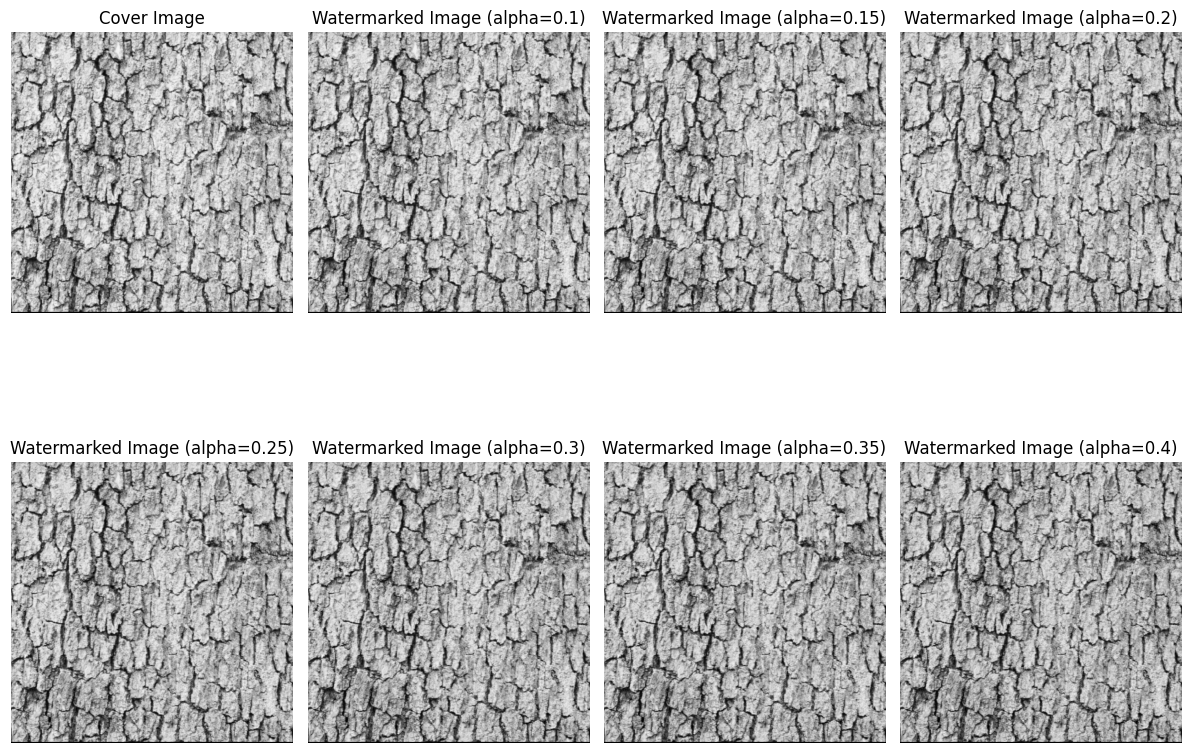

In [5]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 4, figsize=(12, 10))
axes[0, 0].imshow(cover, cmap='gray')
axes[0, 0].set_title('Cover Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(img_w_01, cmap='gray')
axes[0, 1].set_title('Watermarked Image (alpha=0.1)')
axes[0, 1].axis('off')

axes[0, 2].imshow(img_w_015, cmap='gray')
axes[0, 2].set_title('Watermarked Image (alpha=0.15)')
axes[0, 2].axis('off')

axes[0, 3].imshow(img_w_02, cmap='gray')
axes[0, 3].set_title('Watermarked Image (alpha=0.2)')
axes[0, 3].axis('off')

axes[1, 0].imshow(img_w_025, cmap='gray')
axes[1, 0].set_title('Watermarked Image (alpha=0.25)')
axes[1, 0].axis('off')

axes[1, 1].imshow(img_w_03, cmap='gray')
axes[1, 1].set_title('Watermarked Image (alpha=0.3)')
axes[1, 1].axis('off')

axes[1, 2].imshow(img_w_035, cmap='gray')
axes[1, 2].set_title('Watermarked Image (alpha=0.35)')
axes[1, 2].axis('off')

axes[1, 3].imshow(img_w_04, cmap='gray')
axes[1, 3].set_title('Watermarked Image (alpha=0.4)')
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

### PSNR e SSIM (Impercettibilita' del watermark)

In [6]:
from skimage.metrics import structural_similarity as ssim_func
def calculate_quality_metrics(original_image, watermarked_image):
    # Assicurati che le immagini siano della stessa dimensione
    if original_image.shape!= watermarked_image.shape:
        watermarked_image = cv2.resize(watermarked_image, (original_image.shape[1], original_image.shape))

    # Converti in float64 per calcoli precisi
    orig = original_image.astype(np.float64)
    wat = watermarked_image.astype(np.float64)

    # 1. Calcolo MSE (Mean Squared Error)
    mse = np.mean((orig - wat) ** 2)
    
    # 2. Calcolo PSNR
    # Se MSE è 0, le immagini sono identiche
    if mse == 0:
        psnr = float('inf')
    else:
        max_pixel = 255.0
        psnr = 10 * np.log10((max_pixel ** 2) / mse)

    # 3. Calcolo SSIM
    # Specifichiamo data_range=255 per immagini a 8 bit
    ssim_val = ssim_func(original_image, watermarked_image, data_range=255)

    return psnr, ssim_val

In [7]:
psnr_01, ssim_01 = calculate_quality_metrics(cover, img_w_01)
psnr_015, ssim_015 = calculate_quality_metrics(cover, img_w_015)
psnr_02, ssim_02 = calculate_quality_metrics(cover, img_w_02)
psnr_025, ssim_025 = calculate_quality_metrics(cover, img_w_025)
psnr_03, ssim_03 = calculate_quality_metrics(cover, img_w_03)
psnr_035, ssim_035 = calculate_quality_metrics(cover, img_w_035)
psnr_04, ssim_04 = calculate_quality_metrics(cover, img_w_04)

print(f'PSNR (alpha=0.1): {psnr_01:.2f} dB')
print(f'SSIM (alpha=0.1): {ssim_01:.4f} \n')

print(f'PSNR (alpha=0.15): {psnr_015:.2f} dB')
print(f'SSIM (alpha=0.15): {ssim_015:.4f} \n')

print(f'PSNR (alpha=0.2): {psnr_02:.2f} dB')
print(f'SSIM (alpha=0.2): {ssim_02:.4f} \n')

print(f'PSNR (alpha=0.25): {psnr_025:.2f} dB')
print(f'SSIM (alpha=0.25): {ssim_025:.4f} \n')

print(f'PSNR (alpha=0.3): {psnr_03:.2f} dB')
print(f'SSIM (alpha=0.3): {ssim_03:.4f} \n')

print(f'PSNR (alpha=0.35): {psnr_035:.2f} dB')
print(f'SSIM (alpha=0.35): {ssim_035:.4f} \n')

print(f'PSNR (alpha=0.4): {psnr_04:.2f} dB')
print(f'SSIM (alpha=0.4): {ssim_04:.4f} \n')

PSNR (alpha=0.1): 43.50 dB
SSIM (alpha=0.1): 0.9981 

PSNR (alpha=0.15): 40.28 dB
SSIM (alpha=0.15): 0.9958 

PSNR (alpha=0.2): 37.90 dB
SSIM (alpha=0.2): 0.9927 

PSNR (alpha=0.25): 36.02 dB
SSIM (alpha=0.25): 0.9887 

PSNR (alpha=0.3): 34.47 dB
SSIM (alpha=0.3): 0.9840 

PSNR (alpha=0.35): 33.15 dB
SSIM (alpha=0.35): 0.9785 

PSNR (alpha=0.4): 32.00 dB
SSIM (alpha=0.4): 0.9723 



### Attacchi al watermark

In [8]:
def apply_watermarking_attacks(watermarked_img):
    attacks = {}
    img = watermarked_img.copy()
    h, w = img.shape[:2]

    # 1. JPEG Compression
    for q in [90, 70, 50, 30, 10]:
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), q]
        _, encimg = cv2.imencode('.jpg', img, encode_param)
        attacks[f'JPEG_{q}'] = cv2.imdecode(encimg, cv2.IMREAD_GRAYSCALE)

    # 2. Gaussian Noise
    for sigma in [0.1, 0.2, 0.3, 0.4, 0.5]:
        noise = np.random.normal(0, sigma * 255, img.shape).astype(np.float32)
        noisy = img.astype(np.float32) + noise
        attacks[f'GaussianNoise_{sigma}'] = np.clip(noisy, 0, 255).astype(np.uint8)

    # 3. Cropping (con controllo di validità)
    for percent in [0.1, 0.2, 0.3, 0.4]:
        dh, dw = int(h * percent), int(w * percent)
        if h - 2 * dh <= 0 or w - 2 * dw <= 0:
            # crop NON valido → lo saltiamo
            continue
        cropped = img[dh:h-dh, dw:w-dw]
        resized = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_CUBIC)
        attacks[f'Crop_{int(percent*100)}%'] = resized
    # 4. Rotation
    for angle in [5, 10, 15, 20, 25]:
        M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
        rotated = cv2.warpAffine(
            img, M, (w, h),
            flags=cv2.INTER_CUBIC,
            borderMode=cv2.BORDER_REFLECT
        )
        attacks[f'Rotation_{angle}deg'] = rotated
    return attacks


def visualize_attacks(attacks, cols=3):
    n = len(attacks)
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(5 * cols, 5 * rows))

    for i, (name, img) in enumerate(attacks.items(), 1):
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='gray')
        plt.title(name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

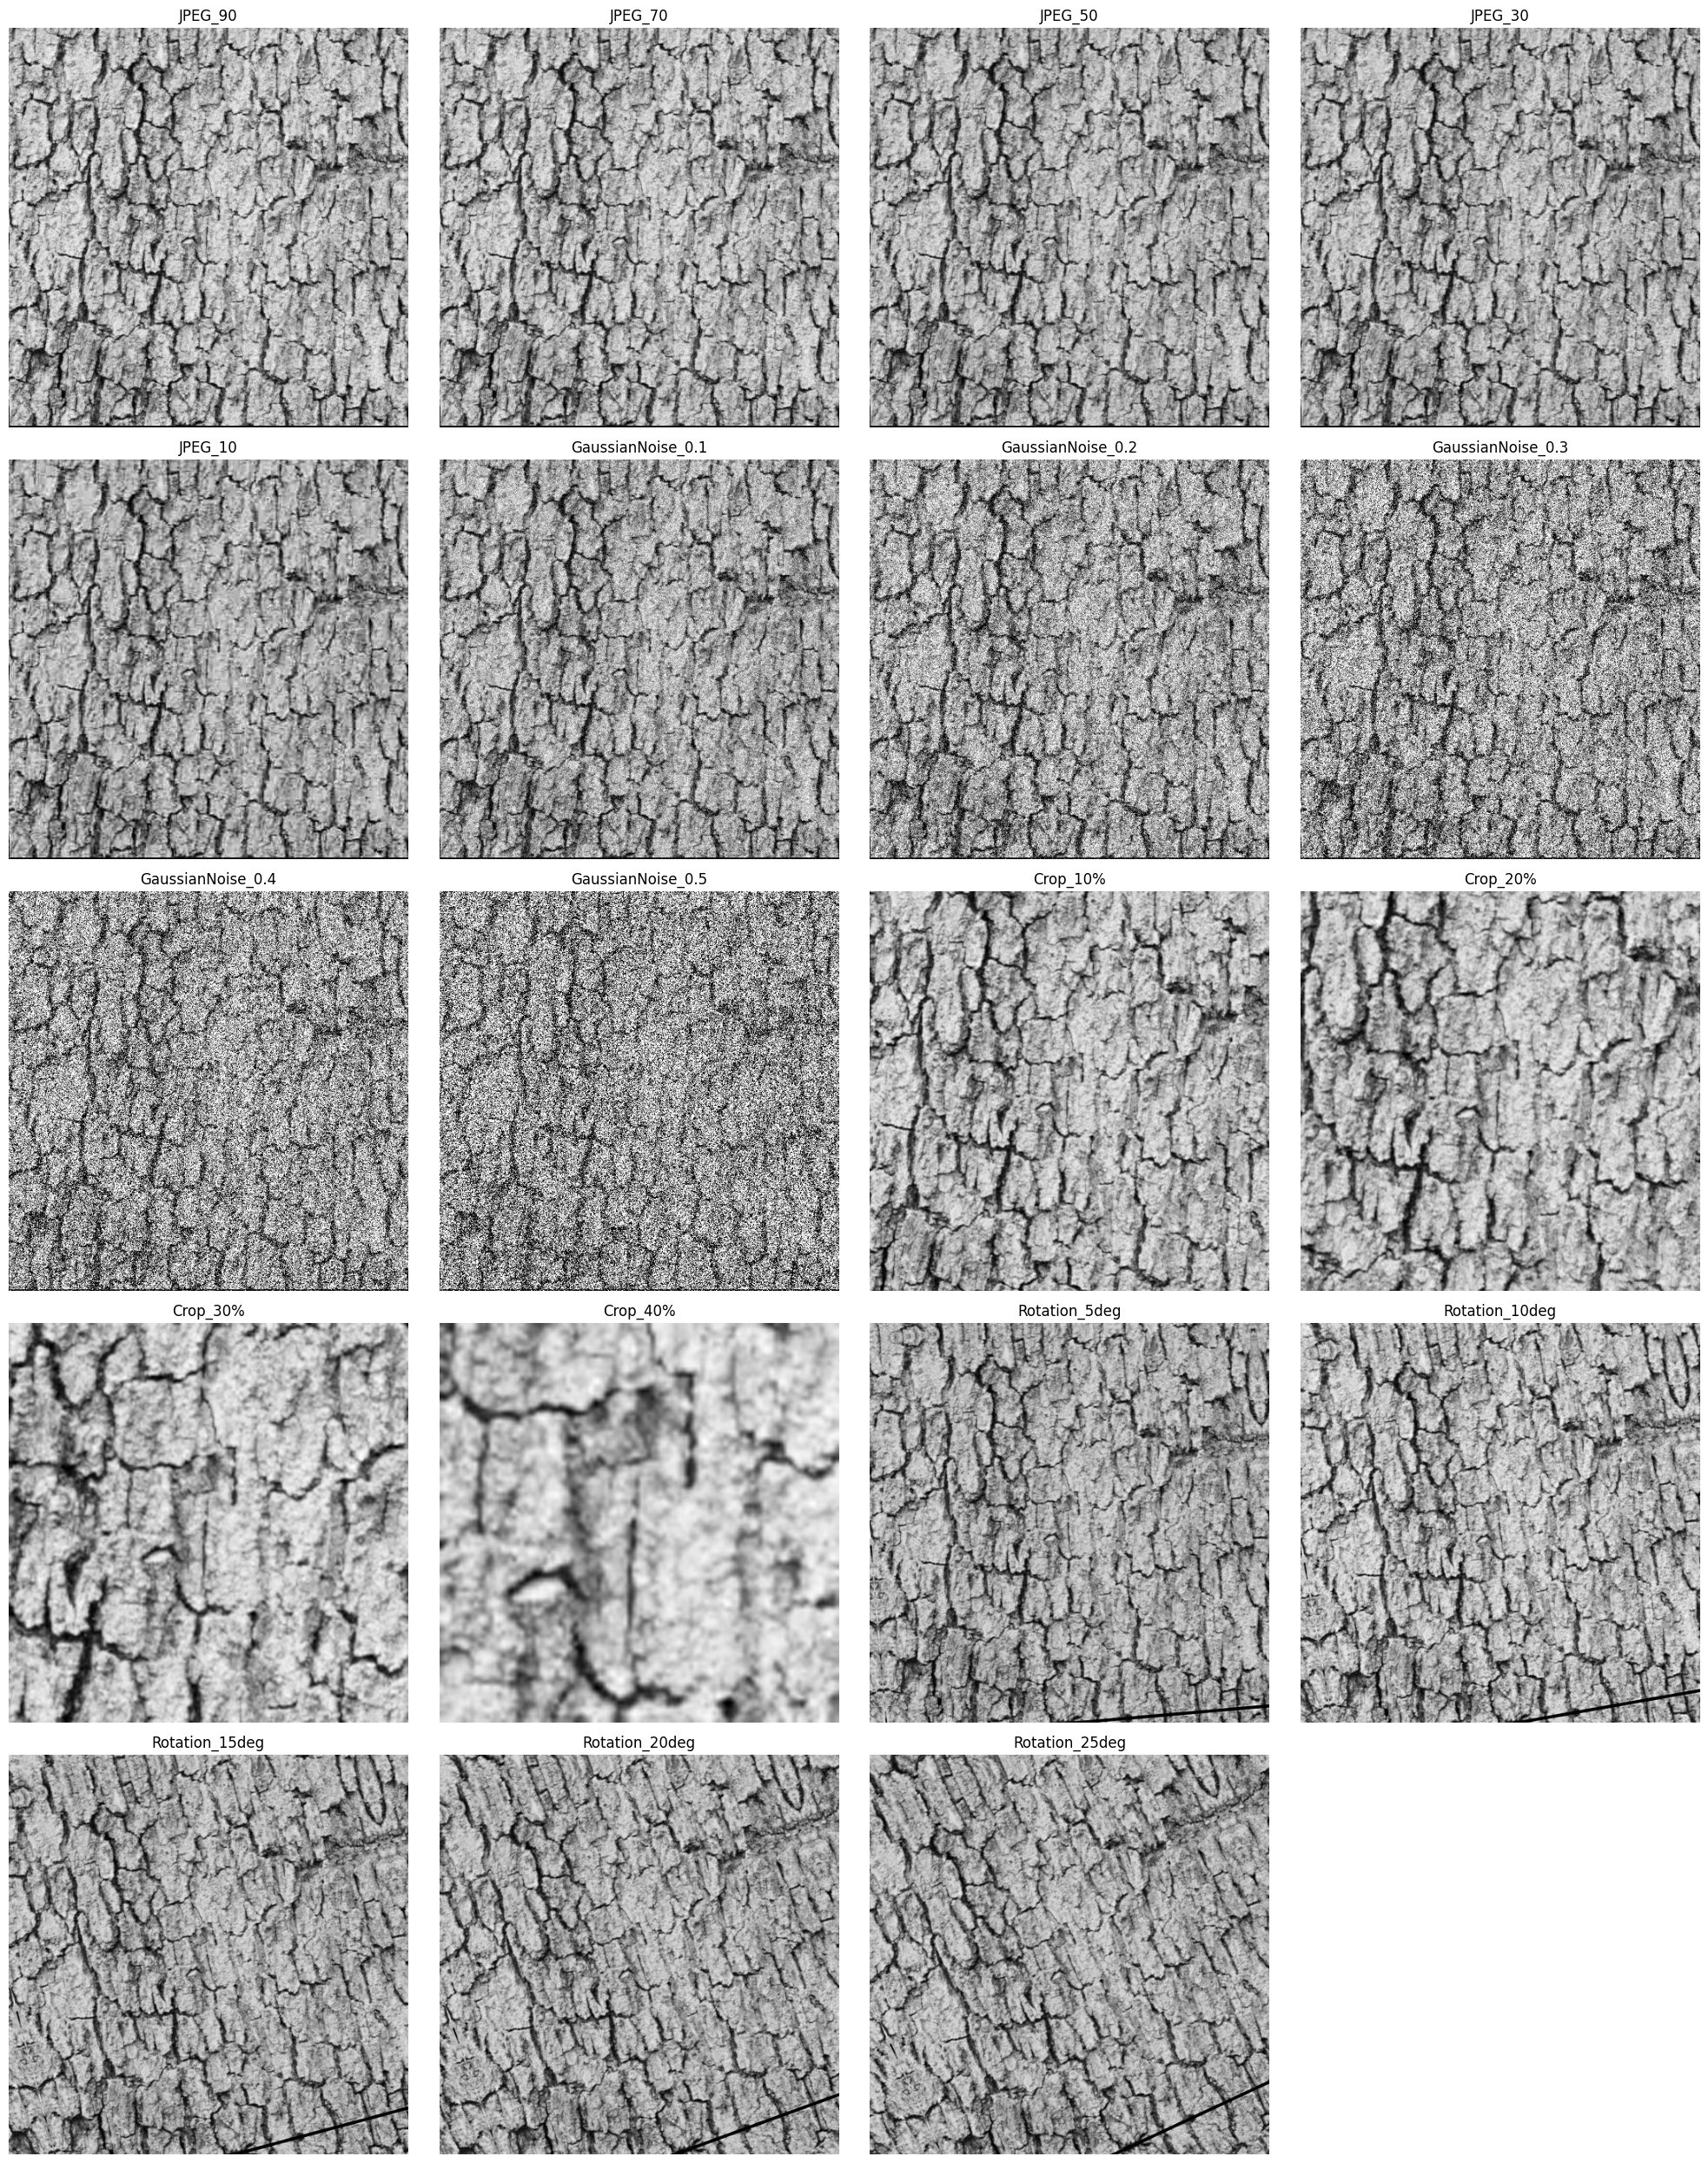

In [9]:
attacked_images = apply_watermarking_attacks(img_w_03)
visualize_attacks(attacked_images, cols=4)

### Valutazione NC e BER

In [10]:
bit_img_jpeg_90 = extract_bit_DWT_DCT_SVD(attacked_images['JPEG_90'], cover)
bit_img_jpeg_70 = extract_bit_DWT_DCT_SVD(attacked_images['JPEG_70'], cover)
bit_img_jpeg_50 = extract_bit_DWT_DCT_SVD(attacked_images['JPEG_50'], cover)
bit_img_jpeg_30 = extract_bit_DWT_DCT_SVD(attacked_images['JPEG_30'], cover)
bit_img_jpeg_10 = extract_bit_DWT_DCT_SVD(attacked_images['JPEG_10'], cover)


bit_img_gaussian_01 = extract_bit_DWT_DCT_SVD(attacked_images['GaussianNoise_0.1'], cover)
bit_img_gaussian_02 = extract_bit_DWT_DCT_SVD(attacked_images['GaussianNoise_0.2'], cover)
bit_img_gaussian_03 = extract_bit_DWT_DCT_SVD(attacked_images['GaussianNoise_0.3'], cover)
bit_img_gaussian_04 = extract_bit_DWT_DCT_SVD(attacked_images['GaussianNoise_0.4'], cover)
bit_img_gaussian_05 = extract_bit_DWT_DCT_SVD(attacked_images['GaussianNoise_0.5'], cover)

bit_img_crop_10 = extract_bit_DWT_DCT_SVD(attacked_images['Crop_10%'], cover)
bit_img_crop_20 = extract_bit_DWT_DCT_SVD(attacked_images['Crop_20%'], cover)
bit_img_crop_30 = extract_bit_DWT_DCT_SVD(attacked_images['Crop_30%'], cover)
bit_img_crop_40 = extract_bit_DWT_DCT_SVD(attacked_images['Crop_40%'], cover)


bit_img_rotation_5 = extract_bit_DWT_DCT_SVD(attacked_images['Rotation_5deg'], cover)
bit_img_rotation_10 = extract_bit_DWT_DCT_SVD(attacked_images['Rotation_10deg'], cover)
bit_img_rotation_15 = extract_bit_DWT_DCT_SVD(attacked_images['Rotation_15deg'], cover)
bit_img_rotation_20 = extract_bit_DWT_DCT_SVD(attacked_images['Rotation_20deg'], cover)
bit_img_rotation_25 = extract_bit_DWT_DCT_SVD(attacked_images['Rotation_25deg'], cover)

ber_jpeg_90, nc_jpeg_90 = calculate_benchmark(msg_originale, bit_img_jpeg_90)
ber_jpeg_70, nc_jpeg_70 = calculate_benchmark(msg_originale, bit_img_jpeg_70)
ber_jpeg_50, nc_jpeg_50 = calculate_benchmark(msg_originale, bit_img_jpeg_50)
ber_jpeg_30, nc_jpeg_30 = calculate_benchmark(msg_originale, bit_img_jpeg_30)
ber_jpeg_10, nc_jpeg_10 = calculate_benchmark(msg_originale, bit_img_jpeg_10)

ber_gaussian_001, nc_gaussian_001 = calculate_benchmark(msg_originale, bit_img_gaussian_01)
ber_gaussian_002, nc_gaussian_002 = calculate_benchmark(msg_originale, bit_img_gaussian_02)
ber_gaussian_003, nc_gaussian_003 = calculate_benchmark(msg_originale, bit_img_gaussian_03)
ber_gaussian_004, nc_gaussian_004 = calculate_benchmark(msg_originale, bit_img_gaussian_04)
ber_gaussian_005, nc_gaussian_005 = calculate_benchmark(msg_originale, bit_img_gaussian_05)

ber_crop_10, nc_crop_10 = calculate_benchmark(msg_originale, bit_img_crop_10)
ber_crop_20, nc_crop_20 = calculate_benchmark(msg_originale, bit_img_crop_20)
ber_crop_30, nc_crop_30 = calculate_benchmark(msg_originale, bit_img_crop_30)
ber_crop_40, nc_crop_40 = calculate_benchmark(msg_originale, bit_img_crop_40)

ber_rotation_5, nc_rotation_5 = calculate_benchmark(msg_originale, bit_img_rotation_5)
ber_rotation_10, nc_rotation_10 = calculate_benchmark(msg_originale, bit_img_rotation_10)
ber_rotation_15, nc_rotation_15 = calculate_benchmark(msg_originale, bit_img_rotation_15)
ber_rotation_20, nc_rotation_20 = calculate_benchmark(msg_originale, bit_img_rotation_20)
ber_rotation_25, nc_rotation_25 = calculate_benchmark(msg_originale, bit_img_rotation_25)

print("-------------------------------------------")
print(f"JPEG 90%: BER={ber_jpeg_90:.4f}, NC={nc_jpeg_90:.4f}")
print(f"JPEG 70%: BER={ber_jpeg_70:.4f}, NC={nc_jpeg_70:.4f}")
print(f"JPEG 50%: BER={ber_jpeg_50:.4f}, NC={nc_jpeg_50:.4f}")
print(f"JPEG 30%: BER={ber_jpeg_30:.4f}, NC={nc_jpeg_30:.4f}")
print(f"JPEG 10%: BER={ber_jpeg_10:.4f}, NC={nc_jpeg_10:.4f}")
print("-------------------------------------------")
print(f"Gaussian Noise 0.1: BER={ber_gaussian_001:.4f}, NC={nc_gaussian_001:.4f}")
print(f"Gaussian Noise 0.2: BER={ber_gaussian_002:.4f}, NC={nc_gaussian_002:.4f}")
print(f"Gaussian Noise 0.3: BER={ber_gaussian_003:.4f}, NC={nc_gaussian_003:.4f}")
print(f"Gaussian Noise 0.4: BER={ber_gaussian_004:.4f}, NC={nc_gaussian_004:.4f}")
print(f"Gaussian Noise 0.5: BER={ber_gaussian_005:.4f}, NC={nc_gaussian_005:.4f}")
print("-------------------------------------------")
print(f"Crop 10%: BER={ber_crop_10:.4f}, NC={nc_crop_10:.4f}")
print(f"Crop 20%: BER={ber_crop_20:.4f}, NC={nc_crop_20:.4f}")
print(f"Crop 30%: BER={ber_crop_30:.4f}, NC={nc_crop_30:.4f}")
print(f"Crop 40%: BER={ber_crop_40:.4f}, NC={nc_crop_40:.4f}")
print("-------------------------------------------")
print(f"Rotation 5°: BER={ber_rotation_5:.4f}, NC={nc_rotation_5:.4f}")
print(f"Rotation 10°: BER={ber_rotation_10:.4f}, NC={nc_rotation_10:.4f}")
print(f"Rotation 15°: BER={ber_rotation_15:.4f}, NC={nc_rotation_15:.4f}")
print(f"Rotation 20°: BER={ber_rotation_20:.4f}, NC={nc_rotation_20:.4f}")
print(f"Rotation 25°: BER={ber_rotation_25:.4f}, NC={nc_rotation_25:.4f}")
print("-------------------------------------------")


-------------------------------------------
JPEG 90%: BER=0.0000, NC=1.0000
JPEG 70%: BER=0.0000, NC=1.0000
JPEG 50%: BER=0.0000, NC=1.0000
JPEG 30%: BER=0.0000, NC=1.0000
JPEG 10%: BER=0.0312, NC=0.9375
-------------------------------------------
Gaussian Noise 0.1: BER=0.2500, NC=0.5000
Gaussian Noise 0.2: BER=0.3750, NC=0.2500
Gaussian Noise 0.3: BER=0.4062, NC=0.1875
Gaussian Noise 0.4: BER=0.4375, NC=0.1250
Gaussian Noise 0.5: BER=0.4375, NC=0.1250
-------------------------------------------
Crop 10%: BER=0.5938, NC=-0.1875
Crop 20%: BER=0.5625, NC=-0.1250
Crop 30%: BER=0.6250, NC=-0.2500
Crop 40%: BER=0.6250, NC=-0.2500
-------------------------------------------
Rotation 5°: BER=0.0000, NC=1.0000
Rotation 10°: BER=0.2812, NC=0.4375
Rotation 15°: BER=0.3438, NC=0.3125
Rotation 20°: BER=0.3438, NC=0.3125
Rotation 25°: BER=0.3750, NC=0.2500
-------------------------------------------


## Esperimenti sul dataset

In [11]:
import os
import csv
import glob

def run_automated_benchmark(input_folder, output_csv, alpha=0.3, num_bits=32):
    # 1. Generazione del messaggio binario (64 bit) 
    # Usiamo un seed fisso per garantire la riproducibilità del benchmark [1, 2]
    np.random.seed(42)
    message = np.random.randint(0, 2, num_bits)
    
    # Prepara il file CSV
    headers = ['nome immagine', 'psnr', 'ssim', 'nome attacco', 'ber', 'nc']
    
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=headers)
        writer.writeheader()
        
        # 2. Cerca tutte le immagini.tiff nella cartella
        image_paths = glob.glob(os.path.join(input_folder, "*.tiff"))
        
        if not image_paths:
            print(f"Nessuna immagine.tiff trovata in {input_folder}")
            return

        for img_path in image_paths:
            img_name = os.path.basename(img_path)
            print(f"Processando: {img_name}...")
            
            # Carica l'immagine originale
            cover = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if cover is None:
                continue
            
            # Ridimensionamento standard per il benchmark (512x512)
            cover = cv2.resize(cover, (512, 512))
            
            # 3. Embedding del watermark
            watermarked_img = embed_bit_DWT_DCT_SVD(cover, message, alpha=alpha)
            
            # 4. Calcolo metriche di qualità (Invisibilità)
            psnr_val, ssim_val = calculate_quality_metrics(cover, watermarked_img)
            
            # 5. Simulazione degli attacchi
            # Restituisce un dizionario: {nome_attacco: immagine_attaccata}
            attacks = apply_watermarking_attacks(watermarked_img)
            
            # 6. Estrazione e calcolo del benchmark per ogni attacco
            for attack_name, attacked_img in attacks.items():
                # Estrazione bit dall'immagine corrotta
                extracted_message = extract_bit_DWT_DCT_SVD(attacked_img, cover, num_bits=num_bits)
                
                # Calcolo BER e NC (Robustezza)
                ber, nc = calculate_benchmark(message, extracted_message)
                
                # Salvataggio riga nel CSV
                writer.writerow({
                    'nome immagine': img_name,
                    'psnr': f"{psnr_val:.4f}",
                    'ssim': f"{ssim_val:.4f}",
                    'nome attacco': attack_name,
                    'ber': f"{ber:.4f}",
                    'nc': f"{nc:.4f}"
                })

    print(f"Benchmark completato. Risultati salvati in: {output_csv}")

In [12]:
run_automated_benchmark(input_folder='data', output_csv='benchmark_results_DWT_DCT_SVD.csv', alpha=0.3, num_bits=32)

Processando: 1.1.01.tiff...
Processando: 1.1.02.tiff...
Processando: 1.1.03.tiff...
Processando: 1.1.04.tiff...
Processando: 1.1.05.tiff...
Processando: 1.1.06.tiff...
Processando: 1.1.07.tiff...
Processando: 1.1.08.tiff...
Processando: 1.1.09.tiff...
Processando: 1.1.10.tiff...
Processando: 1.1.11.tiff...
Processando: 1.1.12.tiff...
Processando: 1.1.13.tiff...
Processando: 1.2.01.tiff...
Processando: 1.2.02.tiff...
Processando: 1.2.03.tiff...
Processando: 1.2.04.tiff...
Processando: 1.2.05.tiff...
Processando: 1.2.06.tiff...
Processando: 1.2.07.tiff...
Processando: 1.2.08.tiff...
Processando: 1.2.09.tiff...
Processando: 1.2.10.tiff...
Processando: 1.2.11.tiff...
Processando: 1.2.12.tiff...
Processando: 1.2.13.tiff...
Processando: 1.3.01.tiff...
Processando: 1.3.02.tiff...
Processando: 1.3.03.tiff...
Processando: 1.3.04.tiff...
Processando: 1.3.05.tiff...
Processando: 1.3.06.tiff...
Processando: 1.3.07.tiff...
Processando: 1.3.08.tiff...
Processando: 1.3.09.tiff...
Processando: 1.3.10.

### Valutazione SSIM e PSNR

In [13]:
import pandas as pd

def evaluate_dataset_imperceptibility(csv_path):
    # 1. Caricamento del file CSV
    df = pd.read_csv(csv_path)
    
    # Assicuriamoci che i valori siano numerici (rimuovendo eventuali spazi)
    df['psnr'] = pd.to_numeric(df['psnr'], errors='coerce')
    df['ssim'] = pd.to_numeric(df['ssim'], errors='coerce')
    
    # 2. Selezione di un solo record per immagine
    # Dato che PSNR e SSIM sono calcolati prima degli attacchi, 
    # prendiamo solo la prima occorrenza per ogni 'nome immagine'
    unique_images_df = df.drop_duplicates(subset=['nome immagine'])
    
    # 3. Calcolo delle medie del dataset
    avg_psnr = unique_images_df['psnr'].mean()
    avg_ssim = unique_images_df['ssim'].mean()
    num_images = len(unique_images_df)
    
    print("-" * 40)
    print(f"RISULTATI MEDI DATASET ({num_images} immagini)")
    print("-" * 40)
    print(f"PSNR Medio: {avg_psnr:.2f} dB")
    print(f"SSIM Medio: {avg_ssim:.4f}")
    print("-" * 40)

evaluate_dataset_imperceptibility('benchmark_results_DWT_DCT_SVD.csv')


----------------------------------------
RISULTATI MEDI DATASET (210 immagini)
----------------------------------------
PSNR Medio: 34.49 dB
SSIM Medio: 0.9183
----------------------------------------


## Valutazione Metriche post-attacchi

In [14]:
def evaluate_attacks_robustness(csv_path):
    # 1. Caricamento dati
    df = pd.read_csv(csv_path)
    
    # Assicuriamoci che i valori siano numerici
    df['ber'] = pd.to_numeric(df['ber'], errors='coerce')
    df['nc'] = pd.to_numeric(df['nc'], errors='coerce')
    
    # 2. Raggruppamento per tipo di attacco
    # Calcoliamo la media di BER e NC per ogni gruppo di attacchi
    attack_summary = df.groupby('nome attacco').agg({
        'ber': 'mean',
        'nc': 'mean'
    }).reset_index()
    
    # 3. Ordinamento per BER crescente (dagli attacchi meno efficaci ai più distruttivi)
    attack_summary = attack_summary.sort_values(by='ber')
    
    # 4. Formattazione e stampa dei risultati
    print("-" * 90)
    print(f"{'NOME ATTACCO':<25} | {'BER MEDIO':<12} | {'NC MEDIA':<10}")
    print("-" * 90)
    
    for _, row in attack_summary.iterrows():
        print(f"{row['nome attacco']:<25} | {row['ber']:<12.4f} | {row['nc']:<10.4f}")
    print("-" * 90)
    
    return attack_summary

report_attacchi = evaluate_attacks_robustness('benchmark_results_DWT_DCT_SVD.csv')

------------------------------------------------------------------------------------------
NOME ATTACCO              | BER MEDIO    | NC MEDIA  
------------------------------------------------------------------------------------------
JPEG_70                   | 0.1045       | 0.7911    
JPEG_90                   | 0.1058       | 0.7884    
JPEG_50                   | 0.1133       | 0.7735    
JPEG_30                   | 0.1272       | 0.7455    
JPEG_10                   | 0.2004       | 0.5991    
Rotation_5deg             | 0.2058       | 0.5884    
Rotation_10deg            | 0.3162       | 0.3676    
Rotation_15deg            | 0.3696       | 0.2607    
GaussianNoise_0.1         | 0.3774       | 0.2452    
Crop_10%                  | 0.3879       | 0.2241    
Rotation_20deg            | 0.4058       | 0.1884    
Rotation_25deg            | 0.4173       | 0.1655    
GaussianNoise_0.2         | 0.4494       | 0.1012    
GaussianNoise_0.3         | 0.4600       | 0.0801    
Gaussian